# **CAT-DOG CLASSIFICATION USING SVM**

Task 3 : Implement a SVM to classify images of cats and dogs from given Kaggle dataset

[*Dogs vs. Cats (Click here)*](https://www.kaggle.com/c/dogs-vs-cats/data)

In this Colab notebook, I will implement an SVM built-in scikit-learn tool to classify images of cats and dogs.

In [ ]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models
from torch.utils.data import DataLoader
import numpy as np
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix

In [ ]:
try:
    from cuml.svm import SVC as cuSVC
    use_gpu_svm = True
    print("Using GPU-accelerated cuML SVM.")
except ImportError:
    use_gpu_svm = False
    print("cuML not available. Using CPU LinearSVC instead.")

cuML not available. Using CPU LinearSVC instead.


### **Shuffle and Create Reqd Dir Structure**

In [ ]:
src_dir = "train"
cat_dir = "data/train/cat"
dog_dir = "data/train/dog"

# Create folders if they don't exist
os.makedirs(cat_dir, exist_ok=True)
os.makedirs(dog_dir, exist_ok=True)

# Move images into corresponding folders
for filename in os.listdir(src_dir):
    if filename.lower().startswith("cat"):
        shutil.move(os.path.join(src_dir, filename), os.path.join(cat_dir, filename))
    elif filename.lower().startswith("dog"):
        shutil.move(os.path.join(src_dir, filename), os.path.join(dog_dir, filename))

In [2]:
from PIL import Image

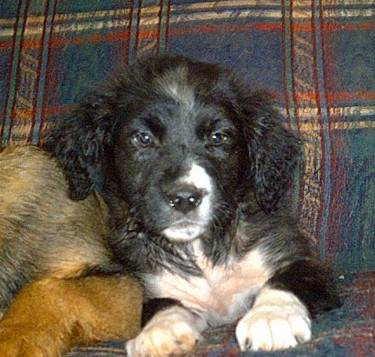

In [3]:
img = Image.open('data/train/dog/dog.1221.jpg')
img

### **Preprocessing and Dataloader**


In [ ]:
data_dir = 'data/train'  # This folder should have /cat and /dog subfolders
batch_size = 32


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])


dataset = datasets.ImageFolder(root=data_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

### **Feature Extraction using VGG16**

In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg16 = models.vgg16(pretrained=True).to(device)
vgg16.classifier = torch.nn.Identity()  # remove final FC layer
vgg16.eval()

features = []
labels = []

with torch.no_grad():
    for inputs, targets in dataloader:
        inputs = inputs.to(device)
        outputs = vgg16(inputs)
        features.append(outputs.cpu().numpy())
        labels.extend(targets.numpy())

X = np.vstack(features)
y = np.array(labels)

print("Extracted Features Shape:", X.shape)
print("Labels Shape:", y.shape)

### **PCA (Dimensionality Reduction)**

In [ ]:
pca = PCA(n_components=256)
X_pca = pca.fit_transform(X)
print("PCA Reduced Shape:", X_pca.shape)

PCA Reduced Shape: (25000, 256)


#### **Train/Test Split**

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y, test_size=0.2, stratify=y, random_state=42)

#### **Train SVM**

In [ ]:

if use_gpu_svm:
    svm = cuSVC(kernel='linear')  # GPU-accelerated
else:
    svm = LinearSVC()  # CPU fallback

print("Training SVM...")
svm.fit(X_train, y_train)

Training SVM...


,penalty,'l2'
,loss,'squared_hinge'
,dual,'auto'
,tol,0.0001
,C,1.0
,multi_class,'ovr'
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,verbose,0
,random_state,None


#### **Evaluate SVM**

In [ ]:

y_pred = svm.predict(X_test)


if use_gpu_svm:
    y_pred = y_pred.get()  # cuDF to NumPy

acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc * 100:.2f}%\n")

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=dataset.classes))

Accuracy: 98.42%

Classification Report:
              precision    recall  f1-score   support

         cat       0.98      0.99      0.98      2500
         dog       0.99      0.98      0.98      2500

    accuracy                           0.98      5000
   macro avg       0.98      0.98      0.98      5000
weighted avg       0.98      0.98      0.98      5000



## RESULTS:

> *This conveys that our SVM is quiet effective and also clues us in on the quality of our dataset, mainly about the fact that it seems to be well labelled and balanced (both cat:0 dog:1 represented fairly)*
### NOTE :
>*We’ve done excellent preprocessing (using feature extraction from pre=trained model VGG16).Especially because raw image pixels alone can not yield this kind of accuracy in an SVM.*

In [9]:
print("Confusion Matrix:\n")
print(confusion_matrix(y_test, y_pred))

Confusion Matrix:

[[2465   35]
 [  44 2456]]


#### **Confusion Matrix**

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
%matplotlib inline
import itertools

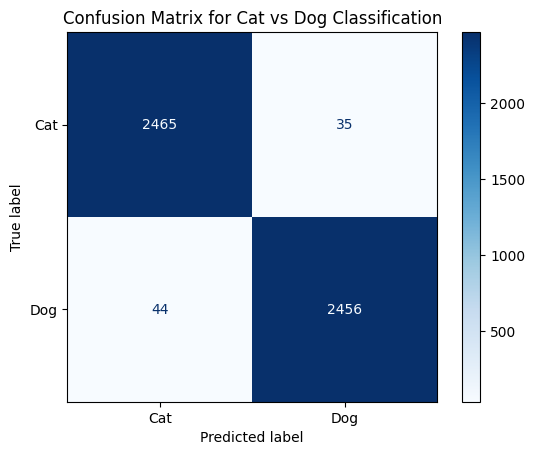

In [18]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Cat', 'Dog'])

disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Cat vs Dog Classification")
plt.show()